# implement line sweeps of params
- all params fixed expcet one, which is swept over range
- specifically looking at test accuracy as a function of one param


In [1]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## timestamp and dir for saving
tstamp = time.perf_counter_ns()
import os
os.mkdir('figures/scratch_folders/%i'%tstamp)

In [3]:
## default params
expargs = {
  'condition':'blocked',
  'n_train':160,
  'n_test':40
}
schargs = {
    'concentration':1.4,
    'stickiness_wi':5000,
    'stickiness_bt':5, # 100
    'sparsity':0.08,
    'pvar': 2,
    'lrate':0.8,
    'lratep':1,
    'decay_rate':1,
} 
args = {
    'sch':schargs,
    'exp':expargs
}
param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
param_str

'concentration_1.400-stickiness_wi_5000.000-stickiness_bt_5.000-sparsity_0.080-pvar_2.000-lrate_0.800-lratep_1.000-decay_rate_1.000'

In [4]:
# p_name = 'concentration' # 
# p_vals = np.arange(0.1,2.5,0.2)

# p_name = 'stickiness_wi' # 5000
# p_vals = np.arange(0,10000,500)

# p_name = 'stickiness_bt' # 100
# p_vals = np.arange(0,10,3)

p_name = 'sparsity' # 0.08
p_vals = np.arange(0.01,2,0.1)

# p_name = 'pvar' # 0
# p_vals = np.arange(1,2,0.1)

# p_name = 'lrate' # 1
# p_vals = np.arange(0.1,1.5,0.05)

# p_name = 'lratep' # 1
# p_vals = np.arange(0.1,2.5,0.2)

# p_name = 'decay_rate' # 1
# p_vals = np.arange(0.99,1.01,0.0005)

p_name,p_vals

('sparsity',
 array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01,
        1.11, 1.21, 1.31, 1.41, 1.51, 1.61, 1.71, 1.81, 1.91]))

### main

In [5]:
def pltsave_macc(macc,schargs=None,labL=['B','I','E','M','L'],close=True):
  """ 
  save accuracy of individual parameter setting 
  used in paramsearch loops
  """
  plt.figure(figsize=(10,4))
  ax=plt.gca()
  for idx in range(len(macc)):
    ax.plot(macc[idx],label=labL[idx])
  ax.axhline(0.5,c='k')
  plt.legend()
  param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
  plt.savefig('figures/scratch_folders/%i/acc-%s.jpg'%(tstamp,param_str))
  if close:
    plt.close('all')
  return None


In [6]:
ns = 15
dfL = []
condL = ['blocked','interleaved','early','middle','late']
for idx,p_val in enumerate(p_vals):
  print(idx/len(p_vals))
  
  args['sch'][p_name] = p_val  
  exp_batch_data = run_batch_exp_curr(ns,args,condL)
  ## acc
  batch_acc = unpack_acc(exp_batch_data) # curr,seeds,trials
  mean_acc = batch_acc.mean(1)
  test_acc = mean_acc[:,-40:].mean(1) # curr  
  
  ## save traces of EML for each param setting
  pltsave_macc(mean_acc[2:],args['sch'],labL=['E','M','L'])
  
  ## record
  gsD = {
    **schargs,
    **dict(zip(condL,test_acc))
  }
  dfL.append(gsD)
  
gsdf = pd.DataFrame(dfL)

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95


In [7]:
gsdf ## test acc dataframe

,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,blocked,interleaved,early,middle,late
0,1.4,5000,5,0.01,2,0.8,1,1,0.835833,1.000000,0.805417,0.965417,0.988333
1,1.4,5000,5,0.11,2,0.8,1,1,1.000000,0.522083,1.000000,0.567083,0.514167
2,1.4,5000,5,0.21,2,0.8,1,1,0.497083,0.502500,0.497083,0.492917,0.507500
3,1.4,5000,5,0.31,2,0.8,1,1,0.518750,0.499167,0.485417,0.491250,0.488333
4,1.4,5000,5,0.41,2,0.8,1,1,0.486250,0.534167,0.520417,0.500833,0.496667
5,1.4,5000,5,0.51,2,0.8,1,1,0.509583,0.492083,0.469167,0.520000,0.517083
6,1.4,5000,5,0.61,2,0.8,1,1,0.493750,0.502500,0.519167,0.484583,0.494583
7,1.4,5000,5,0.71,2,0.8,1,1,0.505000,0.505833,0.506667,0.497917,0.488750
8,1.4,5000,5,0.81,2,0.8,1,1,0.536250,0.485833,0.500417,0.496667,0.514583
9,1.4,5000,5,0.91,2,0.8,1,1,0.493333,0.504583,0.487083,0.490833,0.497083


### plt 

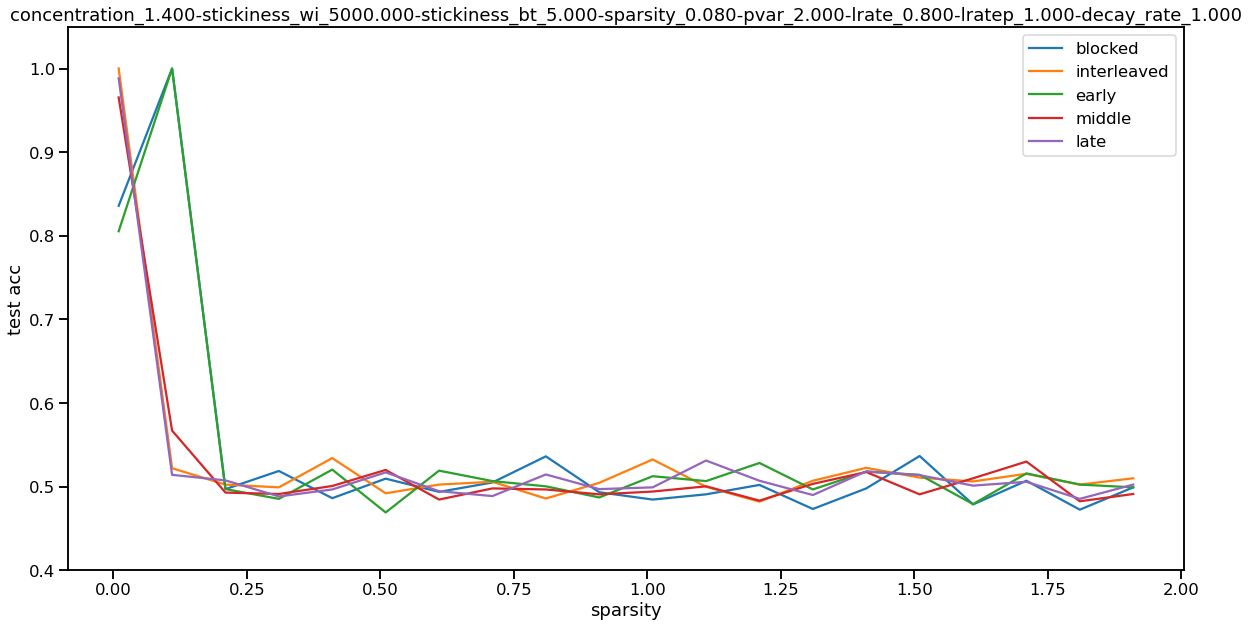

In [8]:
plt.figure(figsize=(20,10))
ax = plt.gca()
gsdf.plot(p_name,condL,ax=ax)
ax.set_ylim(0.4,1.05)
ax.set_ylabel('test acc')
plt.title(param_str)
plt.savefig('figures/scratch/testacc-sweep_%s-default_%s-t%s.png'%(
  p_name,param_str,tstamp))